In [24]:
import pandas as pd
import numpy as np
import seaborn as sns


from tensorflow.keras.layers import Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization, Add
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix

from google.colab import drive

import tensorflow as tf

from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer

import zipfile 
import PIL
%matplotlib inline

In [25]:

drive.mount('/content/drive/')

In [26]:
!ls '/content/drive/My Drive/Neural Network/Proj3_data'

In [27]:
 !unzip '/content/drive/My Drive/Neural Network/Proj3_data/train_identity.csv.zip' -d '/content/drive/My Drive/Neural Network/Proj3_unzip'

In [28]:
!unzip '/content/drive/My Drive/Neural Network/Proj3_data/sample_submission.csv.zip' -d '/content/drive/My Drive/Neural Network/Proj3_unzip'

In [29]:
!unzip '/content/drive/My Drive/Neural Network/Proj3_data/train_transaction.csv.zip' -d '/content/drive/My Drive/Neural Network/Proj3_unzip'

In [30]:


traintransdata = pd.read_csv(r'/content/drive/My Drive/Neural Network/Proj3_unzip/train_transaction.csv', index_col=0)

testtransdata = pd.read_csv(r'/content/drive/My Drive/Neural Network/Proj3_unzip/test_transaction.csv', index_col=0)



In [31]:

indata = pd.read_csv(r'/content/drive/My Drive/Neural Network/Proj3_unzip/train_identity.csv', index_col=0)

test_indata = pd.read_csv(r'/content/drive/My Drive/Neural Network/Proj3_unzip/test_identity.csv', index_col=0)


In [32]:
df = pd.merge(traintransdata, indata, how='left', on=['TransactionID'])
df_test = pd.merge(testtransdata, test_indata, how='left', on=['TransactionID'])

del indata, test_indata, traintransdata, testtransdata   # to free up memory

In [33]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 590540 entries, 2987000 to 3577539
Columns: 433 entries, isFraud to DeviceInfo
dtypes: float64(399), int64(3), object(31)
memory usage: 1.9+ GB


In [34]:
####### this cell reduces the memory usage by changing dtypes
def reduce_memory(df) : 

    for col in df.columns : 
        if str(df[col].dtype) != 'object' :

            max_val = df[col].max()
            min_val = df[col].min()
            max_abs = max(abs(max_val), abs(min_val))

            if  -2**15 <= max_abs < 2**15 : 
                df[col] = df[col].astype(np.float16)

            elif  -2**31 <= max_abs < 2**31 : 
                df[col] = df[col].astype(np.float32)
    
    return df


df = reduce_memory(df)
df_test = reduce_memory(df_test)
print(df.info(), df_test.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 590540 entries, 2987000 to 3577539
Columns: 433 entries, isFraud to DeviceInfo
dtypes: float16(336), float32(66), object(31)
memory usage: 671.3+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 506691 entries, 3663549 to 4170239
Columns: 432 entries, TransactionDT to DeviceInfo
dtypes: float16(335), float32(66), object(31)
memory usage: 575.0+ MB
None None


In [35]:
df_test.columns = df.drop(['isFraud'], axis=1).columns

In [36]:
####### we want to know each object column and their unique values amount 
for col in df.columns : 
    if str(df[col].dtype) == 'object' : 
        print(col, 'has ', len(df[col].unique()), ' unique values')

ProductCD has  5  unique values
card4 has  5  unique values
card6 has  5  unique values
P_emaildomain has  60  unique values
R_emaildomain has  61  unique values
M1 has  3  unique values
M2 has  3  unique values
M3 has  3  unique values
M4 has  4  unique values
M5 has  3  unique values
M6 has  3  unique values
M7 has  3  unique values
M8 has  3  unique values
M9 has  3  unique values
id_12 has  3  unique values
id_15 has  4  unique values
id_16 has  3  unique values
id_23 has  4  unique values
id_27 has  3  unique values
id_28 has  3  unique values
id_29 has  3  unique values
id_30 has  76  unique values
id_31 has  131  unique values
id_33 has  261  unique values
id_34 has  5  unique values
id_35 has  3  unique values
id_36 has  3  unique values
id_37 has  3  unique values
id_38 has  3  unique values
DeviceType has  3  unique values
DeviceInfo has  1787  unique values


In [37]:
######## we one hot vector those who have low unique counts
what_to_one_hot = []
for col in df.columns : 
    if str(df[col].dtype) == 'object' : 
        if len(df[col].unique()) <= 5 : 
            what_to_one_hot.append(col)

df = pd.get_dummies(df, columns=what_to_one_hot)
df_test = pd.get_dummies(df_test, columns=what_to_one_hot)
 ###### shape before one hotting was 433, after one hot encoding became 470

In [38]:
for i in df.columns : 
    if i not in df_test : 
        print(i)

isFraud
card6_debit or credit
id_34_match_status:-1
id_34_match_status:0


In [39]:
####### these are not present in df test so we drop them on df too
df = df.drop(['card6_debit or credit', 'id_34_match_status:-1', 'id_34_match_status:0'], axis=1)

In [40]:
 ####### there remains 4 or 5 columns with object type who have around 1000 unique values and label encoding them wouldnt really help
 
what_to_drop = []
for col in df.columns : 
    if str(df[col].dtype) == 'object' : 
        #print(col, len(df[col].unique()))  
       
        what_to_drop.append(col)

df = df.drop(what_to_drop, axis=1)
df_test = df_test.drop(what_to_drop, axis=1)

In [41]:
###### we drop the columns who have more than 90 percent null values, we'll be having problems with null replacement otherwise
what_to_drop = []

for col in df.columns : 
    if df[col].isnull().sum().sum() / 590540 >= 0.9 : 
        what_to_drop.append(col)

for col in df_test.columns : 
    if df_test[col].isnull().sum().sum() / 506691 >= 0.9 : 
        if col not in what_to_drop : 
            what_to_drop.append(col)

df = df.drop(what_to_drop, axis=1)
df_test = df_test.drop(what_to_drop, axis=1)


In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 590540 entries, 2987000 to 3577539
Columns: 451 entries, isFraud to DeviceType_mobile
dtypes: float16(326), float32(66), uint8(59)
memory usage: 553.6 MB


In [43]:
#################  we split the fraud and not fraud and we fill the nans in our data frames
################# we want to split it because if we dont the mode of not fraud data will dominate the mode on fraud ones
df.sort_values(by=['isFraud'], inplace=True)
df_group = df.groupby(df.isFraud)

df_fraud = df_group.get_group(1)
df_notfraud = df_group.get_group(0)

df_fraud = df_fraud.drop(['isFraud'], axis=1)
df_notfraud = df_notfraud.drop(['isFraud'], axis=1)




df_fraud = df_fraud.replace([np.inf, -np.inf], np.nan)
df_notfraud = df_notfraud.replace([np.inf, -np.inf], np.nan)
df_test = df_test.replace([np.inf, -np.inf], np.nan)


for col in df_fraud.columns : 
    df_fraud[col] = df_fraud[col].fillna(df_fraud[col].mode()[0])

for col in df_notfraud.columns : 
    df_notfraud[col] = df_notfraud[col].fillna(df_notfraud[col].mode()[0])

for col in df_test.columns : 
    df_test[col] = df_test[col].fillna(df_test[col].mode()[0])


print(df_notfraud.isnull().sum().sum(), df_fraud.isnull().sum().sum(), df_test.isnull().sum().sum())

0 0 0


In [47]:
import pandas as pd
from sklearn import preprocessing

def normalize_df(df) : 
    cols = df.columns
    min_max_scaler = preprocessing.MinMaxScaler()
    df_nor = min_max_scaler.fit_transform(df)
    df = pd.DataFrame(df_nor, columns=cols)
    return df

df_fraud = normalize_df(df_fraud)
df_notfraud = normalize_df(df_notfraud)
df_test = normalize_df(df_test)
df_fraud

,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,C1,...,id_35_F,id_35_T,id_36_F,id_36_T,id_37_F,id_37_T,id_38_F,id_38_T,DeviceType_desktop,DeviceType_mobile
0,0.559528,0.076990,0.679594,0.144,0.381679,0.919708,0.190141,0.895349,0.000202,0.000214,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
1,0.433645,0.038467,0.834495,0.780,0.381679,0.919708,0.443662,0.895349,0.000202,0.002137,...,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
2,0.438636,0.037696,0.585086,0.222,0.381679,0.905109,0.509390,0.895349,0.000202,0.000214,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.450036,0.015064,0.083040,0.442,0.381679,0.919708,0.220657,0.895349,0.002832,0.000427,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.199026,0.132270,0.553276,0.966,0.381679,0.919708,0.776995,0.895349,0.000202,0.000427,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20658,0.659998,0.028836,0.489195,0.442,0.381679,0.919708,0.220657,0.895349,0.000202,0.000427,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
20659,0.344394,0.011308,0.785628,0.896,0.381679,0.919708,0.859155,0.895349,0.000202,0.000427,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20660,0.281962,0.516151,0.489195,0.442,0.381679,0.919708,0.330986,0.895349,0.000202,0.000641,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20661,0.491993,0.191403,0.161644,0.022,0.381679,0.868613,0.037559,0.895349,0.000202,0.000214,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [48]:
df_notfraud.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569877 entries, 0 to 569876
Columns: 450 entries, TransactionDT to DeviceType_mobile
dtypes: float32(450)
memory usage: 978.3 MB


In [49]:
 ################### for the anomaly detection approach we'll need to fit the autoencoder with only the df_notfraud data
 ################### but for other techniques df (fraud and notfraud merged) may be needed so we'll create the df again in here

FruadList = [1 for i in range(len(df_fraud) + len(df_notfraud))]
for i in range(len(df_fraud) + 1, len(df_fraud) + len(df_notfraud)) : 
    FruadList[i] = 0

df = pd.concat([df_fraud, df_notfraud])
df['isFraud'] = FruadList

from sklearn.utils import shuffle
df = shuffle(df)

#df = to_float16(df)



print(df['isFraud'].value_counts())
df


0    569876
1     20664
Name: isFraud, dtype: int64


,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,C1,...,id_35_T,id_36_F,id_36_T,id_37_F,id_37_T,id_38_F,id_38_T,DeviceType_desktop,DeviceType_mobile,isFraud
156126,0.916525,0.002898,0.855632,0.890,0.648855,0.277372,0.452273,0.831461,0.00000,0.000213,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0
459483,0.312283,0.000193,0.855632,0.890,0.648855,0.277372,0.452273,0.831461,0.00000,0.000640,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
333406,0.164923,0.003372,0.665287,0.336,0.381679,0.481752,0.538636,0.831461,0.00000,0.000427,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
218757,0.753759,0.002119,0.671724,0.230,0.381679,0.919708,0.097727,0.831461,0.00068,0.000427,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
346487,0.140553,0.003123,0.899770,0.140,0.381679,0.919708,0.790909,0.831461,0.00000,0.000213,...,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12745,0.636807,0.010482,0.106782,0.910,0.381679,0.919708,0.452273,0.831461,0.00068,0.000213,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
137302,0.530472,0.005018,0.841839,0.634,0.381679,0.919708,0.522727,0.831461,0.00000,0.001281,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
517759,0.251463,0.001213,0.234713,0.442,0.381679,0.919708,0.236364,0.831461,0.00000,0.000640,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
446560,0.370667,0.003249,0.231724,0.338,0.381679,0.905109,0.372727,0.831461,0.00000,0.000854,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [50]:












                              ########## end of data cleaning, the df is now ready to use













In [51]:
y_train = df['isFraud']
x_train = df.drop(['isFraud'],axis=1)


There were no Null values.


Next, we will plot the number of frauds and notfrauds.

<AxesSubplot:xlabel='isFraud', ylabel='count'>

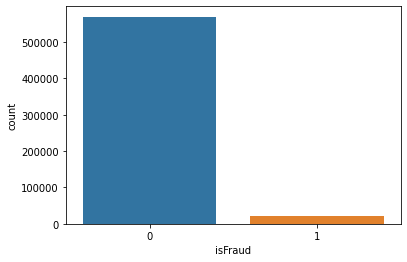

In [52]:
import seaborn as sns

sns.countplot(x = 'isFraud', data = df)

# **AutoEncoder**

In [53]:
df_notfraud

,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,C1,...,id_35_F,id_35_T,id_36_F,id_36_T,id_37_F,id_37_T,id_38_F,id_38_T,DeviceType_desktop,DeviceType_mobile
0,0.000000,0.002137,0.742989,0.442,0.381679,0.306569,0.488636,0.831461,0.001847,0.000213,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.616306,0.001493,0.618391,0.910,0.381679,0.919708,0.050000,0.831461,0.000000,0.002562,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.616304,0.000805,0.108276,0.780,0.381679,0.919708,0.488636,0.831461,0.000000,0.025833,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.616303,0.003123,0.327356,0.022,0.381679,0.693431,0.452273,0.831461,0.000000,0.001281,...,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,0.616301,0.006599,0.356782,0.022,0.381679,0.919708,0.236364,0.831461,0.000000,0.000213,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
569872,0.273810,0.001072,0.517241,0.188,0.381679,0.481752,0.097727,0.831461,0.000000,0.000213,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
569873,0.307276,0.001840,0.731954,0.782,0.381679,0.919708,0.538636,0.831461,0.000000,0.000640,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
569874,0.269051,0.000961,0.666667,0.022,0.381679,0.481752,0.272727,0.831461,0.000000,0.000213,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
569875,0.272950,0.003123,0.811035,0.420,0.381679,0.905109,0.390909,0.831461,0.000000,0.000213,...,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0


In [54]:
df_notfraud

,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,C1,...,id_35_F,id_35_T,id_36_F,id_36_T,id_37_F,id_37_T,id_38_F,id_38_T,DeviceType_desktop,DeviceType_mobile
0,0.000000,0.002137,0.742989,0.442,0.381679,0.306569,0.488636,0.831461,0.001847,0.000213,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.616306,0.001493,0.618391,0.910,0.381679,0.919708,0.050000,0.831461,0.000000,0.002562,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.616304,0.000805,0.108276,0.780,0.381679,0.919708,0.488636,0.831461,0.000000,0.025833,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.616303,0.003123,0.327356,0.022,0.381679,0.693431,0.452273,0.831461,0.000000,0.001281,...,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,0.616301,0.006599,0.356782,0.022,0.381679,0.919708,0.236364,0.831461,0.000000,0.000213,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
569872,0.273810,0.001072,0.517241,0.188,0.381679,0.481752,0.097727,0.831461,0.000000,0.000213,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
569873,0.307276,0.001840,0.731954,0.782,0.381679,0.919708,0.538636,0.831461,0.000000,0.000640,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
569874,0.269051,0.000961,0.666667,0.022,0.381679,0.481752,0.272727,0.831461,0.000000,0.000213,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
569875,0.272950,0.003123,0.811035,0.420,0.381679,0.905109,0.390909,0.831461,0.000000,0.000213,...,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0


In [55]:
for col in df_notfraud.columns:
    df_notfraud[col] = np.array(df_notfraud[col].astype('float16'))


In [56]:
############################# approach 1 : in this approach we'll train the autoEncoder with only the non fradulent data, this way our model
############################# will learn to reconstruct these pattern, which ofcourse comes with a cost
############################# after the training is done we'll do as follows 
############################# we predict the test data which is preproccesed before with 'predictions = model.predict(test_df)
############################# we calculate the the loss with the following pattern (mae or mse) 'error_test = np.mean(np.abs(predictions - test_df))
############################# np.mean is needed because predictions are a serie and we need one single output
############################# now we set a variable treshhold = .... this treshhold has to be calculated manuly by testing
############################# it's function is to just divide the error_test into 2 , those who have higher error than treshold and those who dont 
############################# if a data has higher error than treshold we call it a fraud
############################# to test the accuracy of your test_predictions we can upload them to the kaggle original problem (IEEE Fraud Detection) and test which ############################# treshold works better


############################# approach 2 : in this one we'll train the autoencoder with the df dataset(fraud and notfraud both) 
############################# this autoencoder will learn to compress the data into a dense laten vector 
############################# after the training we use only the encoder part to encode the df again, this time after having the latent vector 
############################# we'll create a simple ANN with input shape of our latent vector and let the classification be done by that 
############################# for test data, again we encode them and predict their latent vector with the ANN

es = EarlyStopping(monitor='val_loss',
                   mode='auto',
                   verbose=1,
                   patience=7)

lrr= ReduceLROnPlateau(monitor='val_loss',
                       factor=0.1, 
                       patience=3, 
                       min_lr=1e-9)



encoder_input = Input(450,name = 'input_encoder')
encoder = Dense(128, activation='tanh',name = 'encoder_layer1')(encoder_input)
encoder = BatchNormalization(name = 'encoder_layer2')(encoder)
encoder = Dropout(0.3 , name = 'encoder_layer3')(encoder)
encoder = Dense(64, activation='relu',name = 'encoder_layer4')(encoder)
encoder = Dense(64, activation='relu',name = 'encoder_layer5')(encoder)
encoder_output = Dense(32, activation='relu',name = 'output_encoder')(encoder)

Encoder = Model(inputs= [encoder_input], outputs=[encoder_output],name = 'Encoder')
#Encoder.summary()



decoder_input = Input(32,name = 'input_decoder')
decoder = Dense(32, activation='tanh',name = 'decoder_layer1')(decoder_input)
decoder = Dense(64, activation='tanh',name = 'decoder_layer2')(decoder)
decoder = BatchNormalization(name = 'decoder_layer3')(decoder)
decoder = Dropout(0.3 , name = 'decoder_layer4')(decoder)
decoder = Dense(64, activation='relu',name = 'decoder_layer5')(decoder)
decoder = Dense(128, activation='relu',name = 'decoder_layer6')(decoder)
decoder_output = Dense(450,activation = 'sigmoid',name ='output_layer')(decoder)

Decoder = Model(inputs= [decoder_input], outputs=[decoder_output],name = 'Decoder')
#Decoder.summary()



autoencoder_input = Input(450, name = 'input_autoencoder')
latent = Encoder(autoencoder_input)
decoded_data = Decoder(latent)
autoencoder = Model(inputs= [autoencoder_input], outputs=[decoded_data], name = 'AutoEncoder')

#autoencoder.summary()


sgd = SGD(lr=0.005, momentum=0.99)
autoencoder.compile(optimizer=sgd, loss='mae')



history = autoencoder.fit(df_notfraud, df_notfraud,
                    batch_size = 32,
                    validation_split = 0.2,
                              epochs= 50,
                              callbacks=[es , lrr])

Epoch 1/50
14247/14247 [==============================] - 33s 2ms/step - loss: 0.0410 - val_loss: 0.0265
Epoch 2/50
14247/14247 [==============================] - 33s 2ms/step - loss: 0.0271 - val_loss: 0.0240
Epoch 3/50
14247/14247 [==============================] - 31s 2ms/step - loss: 0.0244 - val_loss: 0.0196
Epoch 4/50
14247/14247 [==============================] - 32s 2ms/step - loss: 0.0226 - val_loss: 0.0190
Epoch 5/50
14247/14247 [==============================] - 32s 2ms/step - loss: 0.0220 - val_loss: 0.0185
Epoch 6/50
14247/14247 [==============================] - 33s 2ms/step - loss: 0.0217 - val_loss: 0.0181
Epoch 7/50
14247/14247 [==============================] - 33s 2ms/step - loss: 0.0213 - val_loss: 0.0177
Epoch 8/50
14247/14247 [==============================] - 31s 2ms/step - loss: 0.0210 - val_loss: 0.0174
Epoch 9/50
14247/14247 [==============================] - 34s 2ms/step - loss: 0.0208 - val_loss: 0.0173
Epoch 10/50
10471/14247 [=====================>........

KeyboardInterrupt: 

In [ ]:
val_loss = history.history['val_loss']
loss = history.history['loss']

plt.plot(val_loss)
plt.plot(loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Val error', 'Train error'], loc = 'upper right')
plt.savefig('plot_error.png')
plt.show()


In [ ]:
input_model = Input(64, name = 'input_layer')

classifier = Dense(64, activation = 'relu')(input_model)
classifier = Dense(32, activation = 'relu')(classifier)
output = Dense(10, activation = 'relu')(classifier)

classifier = Model(inputs = [input_model], outputs = output)
classifier.summary()


In [ ]:
adam = adam(lr = 0.01, momentum = 0.99)
classifier.compile(optimizer=adam, loss='categorical_crossentropy', 
                   metrics = ['accuracy'])

In [ ]:
es = EarlyStopping(monitor = 'val_loss', mode = 'auto', verbose = 1, patience = 5 )
lrr = ReduceLROnPlateau(monitor = 'vall_loss', factor =0.01, patience =2, min_lr =1e-8)

In [ ]:
train_label = to_categorical(train_labels[:5000])
latent_vector = Encoder.predict(train_data[:5000])
history = classifier.fit(latent_vector, train_label, batch_size = 128,
                         validation_split = 0.2, epochs = 50,
                         verbose = 1, callbacks = [es, lrr])

In [ ]:
val_loss = history.history['val_loss']
loss = history.history['loss']

plt.plot(val_loss)
plt.plot(loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Val error', 'Train error'], loc = 'upper right')
plt.savefig('plot_error.png')
plt.show()


In [ ]:
val_loss = history.history['val_loss']
loss = history.history['loss']

plt.plot(val_loss)
plt.plot(loss)
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend(['Val accuracy', 'Train accuracy'], loc = 'upper right')
plt.savefig('plot_accuracy.png')
plt.show()
